# **Homogeneous Model Verification**

# 1.**Load Moudles**

In [2]:
from codes.HomoFuctions import *

# 2.**Preparation**

## 2.1.**Load highD data**

In [ ]:
## --- Load data of the Location 1
path = '../Datasets/highD/'
file_id  = [11, 12, 13, 14] + [i for i in range(25, 58)]       ### id for location 1          
file_names = [name for name in os.listdir(path) if 'tracks.csv' in name and int(name.split('_')[0]) in file_id]

## --- Upper Lane Boundary
laneBoundary = {}
for id in file_id:
    lane_upper = [float(coor) for coor in pd.read_csv(path + str(id) + '_recordingMeta.csv').upperLaneMarkings[0].split(';')]
    lane_lower = [float(coor) for coor in pd.read_csv(path + str(id) + '_recordingMeta.csv').lowerLaneMarkings[0].split(';')]
    laneBoundary[id] = lane_upper + lane_lower
    
## --- Select data and markings
idx = -1
highd = data_columns_selection(pd.read_csv(path+file_names[idx]))    ### raw dataset
marking = laneBoundary[file_id[idx]]                                ### the marksing

## 2.2.**Data preparation**

In [8]:
## choose the forward direction
highd = highd[highd.laneId>4]

## extract lane-keep/lane-change data
lanekeep = filter_lane_keep_data(highd)
lanechange = filter_lane_change_data(highd)

## extract scenario data
Ld, Fd = 50, 100
# RES = extract_scenario_data(Ld, Fd, lanekeep, highd)
# veh = RES[RES.id==lanekeep[lanekeep.laneId==7].id.unique()[100]]

## 2.3.**Simulation**

### 2.3.1.**Leading Car simulation**

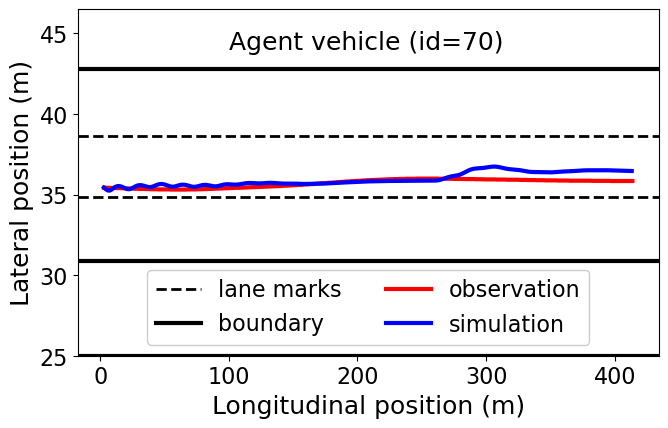

In [13]:
## --- Select the a vehicle trajectory
id = 70
trajectory = highd[highd['id']==id]


## --- Set basic parameters
a, b, s0, T, vd = 2.95, 2.21, 2.58, 1.3, np.sqrt(trajectory.xVelocity**2+trajectory.yVelocity**2).mean() + 1
lf, lr = 2.5, 2.5
a_sigma_d, v_sigma_d, lambda1, lambda2 = 5.81, 5, 25, 75 # car-following

## --- Simulation time
T_frame = trajectory.frame.values
dt, Δx, L = 0.04, 150, 200

## --- Initial status of the simulation vehicle
vehicle_simulation = {T_frame[0]: [sqrt((trajectory.loc[trajectory.index[0]].xVelocity)**2 + (trajectory.loc[trajectory.index[0]].yVelocity)**2), 
                                   trajectory.loc[trajectory.index[0]].x, trajectory.loc[trajectory.index[0]].y,
                                   trajectory.loc[trajectory.index[0]].xVelocity, trajectory.loc[trajectory.index[0]].yVelocity,
                                   trajectory.loc[trajectory.index[0]].xAcceleration, trajectory.loc[trajectory.index[0]].yAcceleration,
                                   -4*np.pi/180, 0, 0 ]}    ### {t:[Vt, x, y, vx, vy, ax, ay, sigma, phi, v_sigma]}

X_e, Y_e = [], []    ### the expected position sets
## --- Simulation
for i in range(1,len(T_frame)):
    
    # Obtain vehicle's status at last step
    [V_last, x_last, y_last, vx_last, vy_last, ax_last, ay_last, sigma_last, phi_last, v_sigma_last] = vehicle_simulation[T_frame[i-1]]
    
    # Obtain the surrounding vehicle's status
    if trajectory[trajectory['frame']==T_frame[i]].laneId.values[0] in [6]:
        ### Front-left lane
        y_lf = marking[-4] - np.diff(marking)[-3] * 0.5    ### the center of the lane 6
        x_lf = Δx + x_last
        V_lf = V_last
            
        ### Front lane: 6
        Front =  highd[(highd['frame']==T_frame[i]) & (highd['laneId']==6) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Front.shape[0]==0:
            y_f = marking[-3] - np.diff(marking)[-3] * 0.5    ### the center of the lane 6
            x_f = Δx + x_last
            V_f = V_last
        else:
            y_f = Front[Front['x']==Front['x'].min()].y.values
            x_f = Front[Front['x']==Front['x'].min()].x.values
            V_f = sqrt((Front[Front['x']==Front['x'].min()].xVelocity.values)**2 + (Front[Front['x']==Front['x'].min()].yVelocity.values)**2)

        ### Front-right lane: 7
        Right = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==7) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Right.shape[0]==0:
            y_rf = marking[-3] + np.diff(marking)[-2] * 0.5    ### the center of the lane 8
            x_rf = Δx + x_last
            V_rf = V_last
        else:
            y_rf = Right[Right['x']==Right['x'].min()].y.values
            x_rf = Right[Right['x']==Right['x'].min()].x.values
            V_rf = sqrt((Right[Right['x']==Right['x'].min()].xVelocity.values)**2 + (Right[Right['x']==Right['x'].min()].yVelocity.values)**2)
    
    
    
    elif trajectory[trajectory['frame']==T_frame[i]].laneId.values[0]==8:
        ### Front-left lane
        y_lf = marking[-1] + np.diff(marking)[-1] * 0.5    ### the center of the lane 6
        x_lf = Δx + x_last
        V_lf = V_last
            
        ### Front lane: 8
        Front =  highd[(highd['frame']==T_frame[i]) & (highd['laneId']==8) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Front.shape[0]==0:
            y_f = marking[-1] - np.diff(marking)[-1] * 0.5    ### the center of the lane 6
            x_f = Δx + x_last
            V_f = V_last
        else:
            y_f = Front[Front['x']==Front['x'].min()].y.values
            x_f = Front[Front['x']==Front['x'].min()].x.values
            V_f = sqrt((Front[Front['x']==Front['x'].min()].xVelocity.values)**2 + (Front[Front['x']==Front['x'].min()].yVelocity.values)**2)

        ### Front-right lane: 7
        Right = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==7) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Right.shape[0]==0:
            y_rf = marking[-3] + np.diff(marking)[-2] * 0.5    ### the center of the lane 8
            x_rf = Δx + x_last
            V_rf = V_last
        else:
            y_rf = Right[Right['x']==Right['x'].min()].y.values
            x_rf = Right[Right['x']==Right['x'].min()].x.values
            V_rf = sqrt((Right[Right['x']==Right['x'].min()].xVelocity.values)**2 + (Right[Right['x']==Right['x'].min()].yVelocity.values)**2)
    
    
    else:            
        ### Front-left lane: 6
        Left = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==6) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Left.shape[0]==0:
            y_lf = marking[-3] - np.diff(marking)[-3] * 0.5    ### the center of the lane 6
            x_lf = Δx + x_last
            V_lf = V_last
        else:
            y_lf = Left[Left['x']==Left['x'].min()].y.values
            x_lf = Left[Left['x']==Left['x'].min()].x.values
            V_lf = sqrt((Left[Left['x']==Left['x'].min()].xVelocity.values)**2 + (Left[Left['x']==Left['x'].min()].yVelocity.values)**2)

        ### Front lane: 7
        Front =  highd[(highd['frame']==T_frame[i]) & (highd['laneId']==7) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Front.shape[0]==0:
            y_f = marking[-3] + np.diff(marking)[-2] * 0.5    ### the center of the lane 6
            x_f = Δx + x_last
            V_f = V_last
        else:
            y_f = Front[Front['x']==Front['x'].min()].y.values
            x_f = Front[Front['x']==Front['x'].min()].x.values
            V_f = sqrt((Front[Front['x']==Front['x'].min()].xVelocity.values)**2 + (Front[Front['x']==Front['x'].min()].yVelocity.values)**2)

        ### Front-right lane: 8
        Right = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==8) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Right.shape[0]==0:
            y_rf = marking[-2] + np.diff(marking)[-1] * 0.5    ### the center of the lane 8
            x_rf = Δx + x_last
            V_rf = V_last
        else:
            y_rf = Right[Right['x']==Right['x'].min()].y.values
            x_rf = Right[Right['x']==Right['x'].min()].x.values
            V_rf = sqrt((Right[Right['x']==Right['x'].min()].xVelocity.values)**2 + (Right[Right['x']==Right['x'].min()].yVelocity.values)**2)

    
    # Calculate the expected position
    x_e = (x_lf + x_f + x_rf) / 3
    y_e = (y_lf + y_f + y_rf) / 3
    V_e = (V_lf + V_f + V_rf) / 3
    X_e.append(x_e)
    Y_e.append(y_e)
    
    # Calculate the 'θ'
    alpha = Get_alpha(x_e, y_e, x_last, y_last)

    # Calculate the 's' and 'Δv'
    d_v = V_e - V_last
    s = sqrt((x_e-x_last)**2 + (y_e-y_last)**2)
    
    # Update vehicular dynamics parameters: 'σ', 'v_σ', 'β', 'φ'
    sigma_new, v_sigma_new = Get_sigma(v_sigma_last, a_sigma_d, v_sigma_d, dt, sigma_last, alpha, lambda1, lambda2)
    
    beta = Get_beta(sigma_new, lr, lf)    ### calculate the 'β'
    
    Va, V_new = IDM(T, vd, s, a, b, s0, dt, d_v, V_last, v_sigma_new, v_sigma_d)
    
    phi_new = Get_phi(V_new, sigma_new, beta, lr, lf, dt, phi_last)
    
    # Update vehicle's status
    vx_new, vy_new, ax_new, ay_new, x_new, y_new = VehicleStatus(Va, V_new, x_last, y_last, vx_last, vy_last, phi_new, sigma_new, dt)
    vehicle_simulation[T_frame[i]] = [V_new, x_new, y_new, vx_new, vy_new, ax_new, ay_new, sigma_new, phi_new, v_sigma_new]



###################################################
## --- Plot the simulation results
colors = [['red', 'blue'], ['green', 'brown'], ['royalblue','orange'], ['blueviolet', 'salmon']]
fig, ax = plt.figure(figsize=(7.5,4.5)), plt.axes()
plot_topology(marking)
color_idx = 0
plt.plot(trajectory.x, trajectory.y, c=colors[color_idx][0], linewidth=3, label='observation')
results = np.array(list(vehicle_simulation.values()))
x, y = results[:, 1], results[:, 2]
plt.plot(x,y,'-',linewidth=3, c=colors[color_idx][1], label='simulation')
plt.xlabel('Longitudinal position (m)', fontsize=18)
plt.ylabel('Lateral position (m)', fontsize=18)
plt.tick_params(labelsize=16) 
plt.ylim(25,46.5)
plt.legend(fontsize=16, framealpha=1,ncol=2,loc='lower center')
plt.text(100, 44, 'Agent vehicle (id='+str(id)+')', fontsize=18)
plt.show()

### 2.3.2.**Replace Real Trajectory with Simulated Trajectory**

In [14]:
results = np.array(list(vehicle_simulation.values()))

trajectroy_simulation = trajectory
trajectroy_simulation['x'] = results[:,1]
trajectroy_simulation['y'] = results[:,2]
trajectroy_simulation['xVelocity'] = results[:,3]
trajectroy_simulation['yVelocity'] = results[:,4]
trajectroy_simulation['xAcceleration'] = results[:,5]
trajectroy_simulation['yAcceleration'] = results[:,6]

highd[highd['id']==id] = trajectroy_simulation

### 2.3.4.**Simulation (Following Cars)**

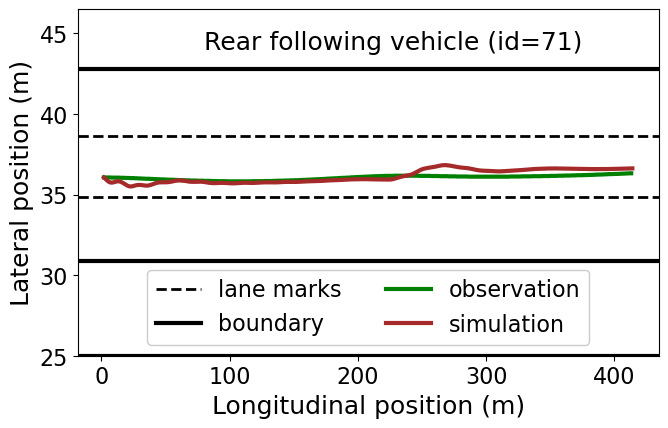

In [19]:
## --- Select the a vehicle trajectory
id = 71
trajectory = highd[highd['id']==id]


## --- Set basic parameters
a, b, s0, T, vd = 2.95, 2.21, 2.58, 1.3, np.sqrt(trajectory.xVelocity**2+trajectory.yVelocity**2).mean() + 2.5
lf, lr = 2.5, 2.5
a_sigma_d, v_sigma_d, lambda1, lambda2 = 5.81, 5, 25, 75 # car-following

## --- Simulation time
T_frame = trajectory.frame.values
dt, Δx, L = 0.04, 150, 200

## --- Initial status of the simulation vehicle
vehicle_simulation = {T_frame[0]: [sqrt((trajectory.loc[trajectory.index[0]].xVelocity)**2 + (trajectory.loc[trajectory.index[0]].yVelocity)**2), 
                                   trajectory.loc[trajectory.index[0]].x, trajectory.loc[trajectory.index[0]].y,
                                   trajectory.loc[trajectory.index[0]].xVelocity, trajectory.loc[trajectory.index[0]].yVelocity,
                                   trajectory.loc[trajectory.index[0]].xAcceleration, trajectory.loc[trajectory.index[0]].yAcceleration,
                                   -4*np.pi/180, 0, 0 ]}    ### {t:[Vt, x, y, vx, vy, ax, ay, sigma, phi, v_sigma]}

X_e, Y_e = [], []    ### the expected position sets

## --- Simulation
for i in range(1,len(T_frame)):
    
    # Obtain vehicle's status at last step
    [V_last, x_last, y_last, vx_last, vy_last, ax_last, ay_last, sigma_last, phi_last, v_sigma_last] = vehicle_simulation[T_frame[i-1]]
    
    # Obtain the surrounding vehicle's status
    if trajectory[trajectory['frame']==T_frame[i]].laneId.values[0] in [6]:
        ### Front-left lane
        y_lf = marking[-4] - np.diff(marking)[-3] * 0.5    ### the center of the lane 6
        x_lf = Δx + x_last
        V_lf = V_last
            
        ### Front lane: 6
        Front =  highd[(highd['frame']==T_frame[i]) & (highd['laneId']==6) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Front.shape[0]==0:
            y_f = marking[-3] - np.diff(marking)[-3] * 0.5    ### the center of the lane 6
            x_f = Δx + x_last
            V_f = V_last
        else:
            y_f = Front[Front['x']==Front['x'].min()].y.values
            x_f = Front[Front['x']==Front['x'].min()].x.values
            V_f = sqrt((Front[Front['x']==Front['x'].min()].xVelocity.values)**2 + (Front[Front['x']==Front['x'].min()].yVelocity.values)**2)

        ### Front-right lane: 7
        Right = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==7) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Right.shape[0]==0:
            y_rf = marking[-3] + np.diff(marking)[-2] * 0.5    ### the center of the lane 8
            x_rf = Δx + x_last
            V_rf = V_last
        else:
            y_rf = Right[Right['x']==Right['x'].min()].y.values
            x_rf = Right[Right['x']==Right['x'].min()].x.values
            V_rf = sqrt((Right[Right['x']==Right['x'].min()].xVelocity.values)**2 + (Right[Right['x']==Right['x'].min()].yVelocity.values)**2)
    
    
    
    elif trajectory[trajectory['frame']==T_frame[i]].laneId.values[0]==8:
        ### Front-left lane
        y_lf = marking[-1] + np.diff(marking)[-1] * 0.5    ### the center of the lane 6
        x_lf = Δx + x_last
        V_lf = V_last
            
        ### Front lane: 8
        Front =  highd[(highd['frame']==T_frame[i]) & (highd['laneId']==8) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Front.shape[0]==0:
            y_f = marking[-1] - np.diff(marking)[-1] * 0.5    ### the center of the lane 6
            x_f = Δx + x_last
            V_f = V_last
        else:
            y_f = Front[Front['x']==Front['x'].min()].y.values
            x_f = Front[Front['x']==Front['x'].min()].x.values
            V_f = sqrt((Front[Front['x']==Front['x'].min()].xVelocity.values)**2 + (Front[Front['x']==Front['x'].min()].yVelocity.values)**2)

        ### Front-right lane: 7
        Right = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==7) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Right.shape[0]==0:
            y_rf = marking[-3] + np.diff(marking)[-2] * 0.5    ### the center of the lane 8
            x_rf = Δx + x_last
            V_rf = V_last
        else:
            y_rf = Right[Right['x']==Right['x'].min()].y.values
            x_rf = Right[Right['x']==Right['x'].min()].x.values
            V_rf = sqrt((Right[Right['x']==Right['x'].min()].xVelocity.values)**2 + (Right[Right['x']==Right['x'].min()].yVelocity.values)**2)
    
    
    else:            
        ### Front-left lane: 6
        Left = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==6) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Left.shape[0]==0:
            y_lf = marking[-3] - np.diff(marking)[-3] * 0.5    ### the center of the lane 6
            x_lf = Δx + x_last
            V_lf = V_last
        else:
            y_lf = Left[Left['x']==Left['x'].min()].y.values
            x_lf = Left[Left['x']==Left['x'].min()].x.values
            V_lf = sqrt((Left[Left['x']==Left['x'].min()].xVelocity.values)**2 + (Left[Left['x']==Left['x'].min()].yVelocity.values)**2)

        ### Front lane: 7
        Front =  highd[(highd['frame']==T_frame[i]) & (highd['laneId']==7) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Front.shape[0]==0:
            y_f = marking[-3] + np.diff(marking)[-2] * 0.5    ### the center of the lane 6
            x_f = Δx + x_last
            V_f = V_last
        else:
            y_f = Front[Front['x']==Front['x'].min()].y.values
            x_f = Front[Front['x']==Front['x'].min()].x.values
            V_f = sqrt((Front[Front['x']==Front['x'].min()].xVelocity.values)**2 + (Front[Front['x']==Front['x'].min()].yVelocity.values)**2)

        ### Front-right lane: 8
        Right = highd[(highd['frame']==T_frame[i]) & (highd['laneId']==8) & (highd['x']>x_last) & (highd['x']<=x_last+L)]
        if Right.shape[0]==0:
            y_rf = marking[-2] + np.diff(marking)[-1] * 0.5    ### the center of the lane 8
            x_rf = Δx + x_last
            V_rf = V_last
        else:
            y_rf = Right[Right['x']==Right['x'].min()].y.values
            x_rf = Right[Right['x']==Right['x'].min()].x.values
            V_rf = sqrt((Right[Right['x']==Right['x'].min()].xVelocity.values)**2 + (Right[Right['x']==Right['x'].min()].yVelocity.values)**2)

    
    # Calculate the expected position
    x_e = (x_lf + x_f + x_rf) / 3
    y_e = (y_lf + y_f + y_rf) / 3
    V_e = (V_lf + V_f + V_rf) / 3
    X_e.append(x_e)
    Y_e.append(y_e)
    
    # Calculate the 'θ'
    alpha = Get_alpha(x_e, y_e, x_last, y_last)

    # Calculate the 's' and 'Δv'
    d_v = V_e - V_last
    s = sqrt((x_e-x_last)**2 + (y_e-y_last)**2)
    
    # Update vehicular dynamics parameters: 'σ', 'v_σ', 'β', 'φ'
    sigma_new, v_sigma_new = Get_sigma(v_sigma_last, a_sigma_d, v_sigma_d, dt, sigma_last, alpha, lambda1, lambda2)
    
    beta = Get_beta(sigma_new, lr, lf)    ### calculate the 'β'
    
    Va, V_new = IDM(T, vd, s, a, b, s0, dt, d_v, V_last, v_sigma_new, v_sigma_d)
    
    phi_new = Get_phi(V_new, sigma_new, beta, lr, lf, dt, phi_last)
    
    # Update vehicle's status
    vx_new, vy_new, ax_new, ay_new, x_new, y_new = VehicleStatus(Va, V_new, x_last, y_last, vx_last, vy_last, phi_new, sigma_new, dt)
    vehicle_simulation[T_frame[i]] = [V_new, x_new, y_new, vx_new, vy_new, ax_new, ay_new, sigma_new, phi_new, v_sigma_new]



###################################################
## --- Plot the simulation results
colors = [['red', 'blue'], ['green', 'brown'], ['royalblue','orange'], ['blueviolet', 'salmon']]
fig, ax = plt.figure(figsize=(7.5,4.5)), plt.axes()
plot_topology(marking)
color_idx = 1
plt.plot(trajectory.x, trajectory.y, c=colors[color_idx][0], linewidth=3, label='observation')
results = np.array(list(vehicle_simulation.values()))
x, y = results[:, 1], results[:, 2]
plt.plot(x,y,'-',linewidth=3, c=colors[color_idx][1], label='simulation')
plt.xlabel('Longitudinal position (m)', fontsize=18)
plt.ylabel('Lateral position (m)', fontsize=18)
plt.tick_params(labelsize=16) 
plt.ylim(25,46.5)
plt.legend(fontsize=16, framealpha=1,ncol=2,loc='lower center')
plt.text(80, 44, 'Rear following vehicle (id='+str(id)+')', fontsize=18)
plt.show()